## Notebook to focus only only Inference with Finetuned Prithvi

In [1]:
%pip install huggingface_hub

Note: you may need to restart the kernel to use updated packages.


In [3]:
from mmcv import Config

from mmseg.apis import init_segmentor
from model_inference import inference_segmentor, process_test_pipeline
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt
import matplotlib
from torch import nn
import numpy as np
import rasterio

NO_DATA = -9999
NO_DATA_FLOAT = 0.0001
PERCENTILES = (0.1, 99.9)

### Define some functions for visualization

In [4]:
def load_raster(path, crop=None):
    with rasterio.open(path) as src:
        img = src.read()

        # load first 6 bands
        img = img[:6]

        img = np.where(img == NO_DATA, NO_DATA_FLOAT, img)
        if crop:
            img = img[:, -crop[0]:, -crop[1]:]
    return img

def enhance_raster_for_visualization(raster, ref_img=None):
    if ref_img is None:
        ref_img = raster
    channels = []
    for channel in range(raster.shape[0]):
        valid_mask = np.ones_like(ref_img[channel], dtype=bool)
        valid_mask[ref_img[channel] == NO_DATA_FLOAT] = False
        mins, maxs = np.percentile(ref_img[channel][valid_mask], PERCENTILES)
        normalized_raster = (raster[channel] - mins) / (maxs - mins)
        normalized_raster[~valid_mask] = 0
        clipped = np.clip(normalized_raster, 0, 1)
        channels.append(clipped)
    clipped = np.stack(channels)
    channels_last = np.moveaxis(clipped, 0, -1)[..., :3]
    rgb = channels_last[..., ::-1]
    return rgb

def plot_image_mask_reconstruction(normalized, mask_img, pred_img):
    # Mix visible and predicted patches
    rec_img = normalized.clone()
    rec_img[mask_img == 1] = pred_img[mask_img == 1]  # binary mask: 0 is keep, 1 is remove

    mask_img_np = mask_img.numpy().reshape(6, 224, 224).transpose((1, 2, 0))[..., :3]

    rec_img_np = (rec_img.numpy().reshape(6, 224, 224) * stds) + means
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))

    for subplot in ax:
        subplot.axis('off')

    ax[0].imshow(enhance_raster_for_visualization(input_data))
    masked_img_np = enhance_raster_for_visualization(input_data).copy()
    masked_img_np[mask_img_np[..., 0] == 1] = 0
    ax[1].imshow(masked_img_np)
    ax[2].imshow(enhance_raster_for_visualization(rec_img_np, ref_img=input_data))

In [7]:
def get_model(application_name):
   
    if application_name == "flood_mapping":
        repo_id = "ibm-nasa-geospatial/Prithvi-100M-sen1floods11"
        config_filename = "sen1floods11_Prithvi_100M.py"
        ckpt_filename = "sen1floods11_Prithvi_100M.pth"
    elif application_name == "burn_scars":
        repo_id = "ibm-nasa-geospatial/Prithvi-100M-burn-scar"
        config_filename = "burn_scars_Prithvi_100M.py"
        ckpt_filename = "burn_scars_Prithvi_100M.pth"
    elif application_name == "cover_crop":
        repo_id = "ibm-nasa-geospatial/Prithvi-100M-multi-temporal-crop-classification"
        config_filename = "multi_temporal_crop_classification_Prithvi_100M.py"
        ckpt_filename = "multi_temporal_crop_classification_Prithvi_100M.pth"
    
    config_path=hf_hub_download(repo_id=repo_id, filename=config_filename)
    ckpt=hf_hub_download(repo_id=repo_id, filename=ckpt_filename)
    finetuned_model = init_segmentor(Config.fromfile(config_path), ckpt, device="cpu")
    return finetuned_model

In [8]:
finetuned_model = get_model("flood_mapping")

/Users/mohanar2/Desktop/IBM - Cloud Project (HDC)/clowder2/venv/lib/python3.9/site-packages/mmseg/models/decode_heads/decode_head.py:104: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert seg_logist into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/Users/mohanar2/Desktop/IBM - Cloud Project (HDC)/clowder2/venv/lib/python3.9/site-packages/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: /Users/mohanar2/.cache/huggingface/hub/models--ibm-nasa-geospatial--Prithvi-100M-sen1floods11/snapshots/220f62f00f6a31a70daac7babf139e4bf265f1c0/sen1floods11_Prithvi_100M.pth


### Let's grab an image to do inference on

In [9]:
!wget https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-sen1floods11-demo/resolve/main/Spain_7370579_S2Hand.tif

--2024-03-15 11:38:49--  https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-sen1floods11-demo/resolve/main/Spain_7370579_S2Hand.tif
Resolving huggingface.co (huggingface.co)... 18.172.134.4, 18.172.134.88, 18.172.134.124, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/f5/58/f558b73cabb08f1c54cb2db126d55670236aeb76a5eac5a5e63e5fb296eb1f5a/16e997e6a7159fa11160faf00591da763eb37ac82faf806f7fe733991944a048?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27Spain_7370579_S2Hand.tif%3B+filename%3D%22Spain_7370579_S2Hand.tif%22%3B&response-content-type=image%2Ftiff&Expires=1710779929&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxMDc3OTkyOX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9mNS81OC9mNTU4YjczY2FiYjA4ZjFjNTRjYjJkYjEyNmQ1NTY3MDIzNmFlYjc2YTVlYWM1YTVlNjNlNWZiMjk2ZWIxZjV

## Perform the inference

In [10]:
# adapt this pipeline for Tif files with > 3 images
custom_test_pipeline = process_test_pipeline(finetuned_model.cfg.data.test.pipeline)
result = inference_segmentor(finetuned_model, "Spain_7370579_S2Hand.tif", custom_test_pipeline=custom_test_pipeline)

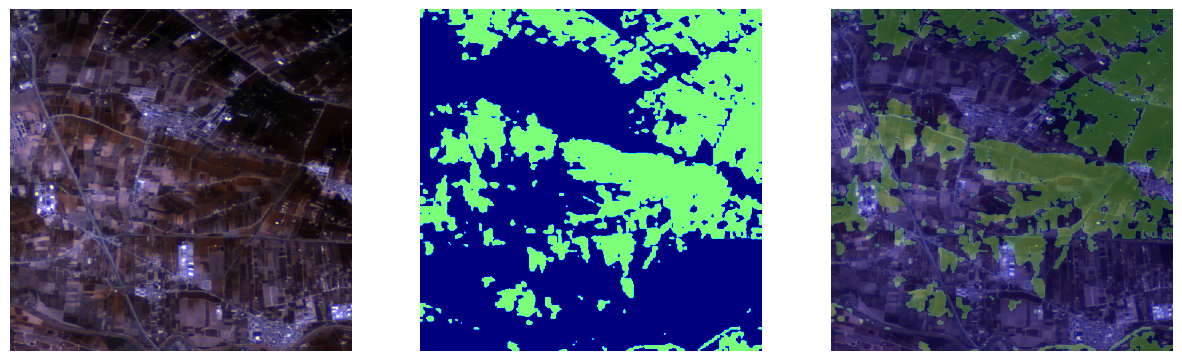

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
input_data_inference = load_raster("Spain_7370579_S2Hand.tif")
norm = matplotlib.colors.Normalize(vmin=0, vmax=2)
ax[0].imshow(enhance_raster_for_visualization(input_data_inference))
ax[1].imshow(result[0], norm=norm, cmap="jet")
ax[2].imshow(enhance_raster_for_visualization(input_data_inference))
ax[2].imshow(result[0], cmap="jet", alpha=0.3, norm=norm)
for subplot in ax:
    subplot.axis('off')